<a href="https://colab.research.google.com/github/Akshay1897/COVID-19-Predictions/blob/master/COVID19_INDIA_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries

In [0]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set()

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

In [49]:
!pip install pywaffle
!pip install pycountry

In [50]:
py.init_notebook_mode(connected=True)
import folium
from folium import plugins

Increasing default plot size and setting the color scheme

In [0]:
plt.rcParams['figure.figsize'] = 8, 5

In [0]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Disabling warnings

In [0]:
import warnings
warnings.filterwarnings('ignore')

## A.] Analysing the present condition in INDIA

![alt text](https://imgur.com/6wtDrrQ.png)

Reading datasets

In [0]:
from google.colab import files
df= pd.read_csv('Covid cases in India.csv')
df_india = df.copy()

In [0]:
India_coord = pd.read_csv('Indian Coordinates.csv')

Day by day data of India, Korea and Italy

In [0]:
dbd_India = pd.read_excel('per_day_cases.xlsx',sheet_name='India')
dbd_Italy = pd.read_excel('per_day_cases.xlsx',sheet_name="Italy")
dbd_Korea = pd.read_excel('per_day_cases.xlsx',sheet_name="Korea")

In [57]:
df.drop(['S. No.'],axis=1,inplace=True)
df['Total cases'] = df['Total Confirmed cases (Indian National)'] + df['Total Confirmed cases ( Foreign National )'] 
df['Active cases'] = df['Total cases'] - (df['Cured/Discharged/Migrated'] + df['Deaths'])
print(f'Total number of Confirmed COVID 2019 cases across India:', df['Total cases'].sum())
print(f'Total number of Active COVID 2019 cases across India:', df['Active cases'].sum())
print(f'Total number of Cured/Discharged/Migrated COVID 2019 cases across India:', df['Cured/Discharged/Migrated'].sum())
print(f'Total number of Deaths due to COVID 2019  across India:', df['Deaths'].sum())
print(f'Total number of States/UTs affected:', len(df['Name of State / UT']))

Total number of Confirmed COVID 2019 cases across India: 360
Total number of Active COVID 2019 cases across India: 329
Total number of Cured/Discharged/Migrated COVID 2019 cases across India: 24
Total number of Deaths due to COVID 2019  across India: 7
Total number of States/UTs affected: 23


1.1 Distribution of Cases in INDIA

In [58]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: pink' if v else '' for v in is_max]

df.style.apply(highlight_max,subset=['Cured/Discharged/Migrated', 'Deaths','Total cases','Active cases'])

1.2 Nationality

In [59]:
colors = ['#1f77b4', '#17becf']

indian = df['Total Confirmed cases (Indian National)'].sum()
foreign = df['Total Confirmed cases ( Foreign National )'].sum()
fig = go.Figure(data=[go.Pie(labels=['Indian','Foreign Nationals'],
                             values= [indian,foreign],hole =.3)])
                          

fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#FFFFFF', width=2)))
fig.show(renderer = "colab")

1.3 State/Union Territories wise number of Covid-19 cases

In [60]:
x = df.groupby('Name of State / UT')['Active cases'].sum().sort_values(ascending=False).to_frame()
x.style.background_gradient(cmap='Reds')

In [61]:
fig = px.bar(df.sort_values('Active cases', ascending=False).sort_values('Active cases', ascending=True), 
             x="Active cases", y="Name of State / UT", 
             title='Total Active Cases', 
             text='Active cases', 
             orientation='h', 
             width=1000, height=700, range_x = [0, max(df['Active cases'])])
fig.update_traces(marker_color='#46cdcf', opacity=0.8, textposition='inside')

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show(renderer = "colab")

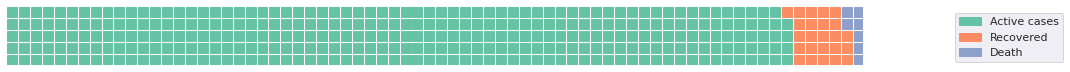

In [62]:
from pywaffle import Waffle

df_condensed = pd.DataFrame([df['Active cases'].sum(),df['Cured/Discharged/Migrated'].sum(),df['Deaths'].sum()],columns=['Cases'])
df_condensed.index=['Active cases','Recovered','Death']
df_condensed


fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    values=df_condensed['Cases'],
    labels=list(df_condensed.index),
    figsize=(15,5),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)

1.4 National v/s Foreign cases

In [63]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("National Cases","Foreign Cases"))

temp = df.sort_values('Total Confirmed cases (Indian National)', ascending=False).sort_values('Total Confirmed cases (Indian National)', ascending=False)

fig.add_trace(go.Bar( y=temp['Total Confirmed cases (Indian National)'], x=temp["Name of State / UT"],  
                     marker=dict(color=temp['Total Confirmed cases (Indian National)'], coloraxis="coloraxis")),
              1, 1)
                     
temp1 = df.sort_values('Total Confirmed cases ( Foreign National )', ascending=False).sort_values('Total Confirmed cases ( Foreign National )', ascending=False)

fig.add_trace(go.Bar( y=temp1['Total Confirmed cases ( Foreign National )'], x=temp1["Name of State / UT"],  
                     marker=dict(color=temp1['Total Confirmed cases ( Foreign National )'], coloraxis="coloraxis")),
              1, 2)                     
                     

fig.update_layout(coloraxis=dict(colorscale='rdbu'), showlegend=False,title_text="National vs Foreign Cases",plot_bgcolor='rgb(250, 242, 242)')
fig.show(renderer = "colab")

1.5 Visualising the spread geographically

In [64]:
# creating map

df_full = pd.merge(India_coord,df,on='Name of State / UT')
map = folium.Map(location=[20, 80], zoom_start=3.5,tiles='Stamen Toner')

for lat, lon, value, name in zip(df_full['Latitude'], df_full['Longitude'], df_full['Active cases'], df_full['Name of State / UT']):
    folium.CircleMarker([lat, lon],
                        radius=value*0.7,
                        popup = ('<strong>State</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>Active Cases</strong>: ' + str(value) + '<br>'),
                        color='red',
                        
                        fill_color='red',
                        fill_opacity=0.3 ).add_to(map)
map

In [65]:
%%HTML
<div class='tableauPlaceholder' id='viz1584844523244' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bo&#47;Book1_31496&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Book1_31496&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bo&#47;Book1_31496&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1584844523244');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='650px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='650px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='727px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

1.6 Confirmed v/s Recovered figures

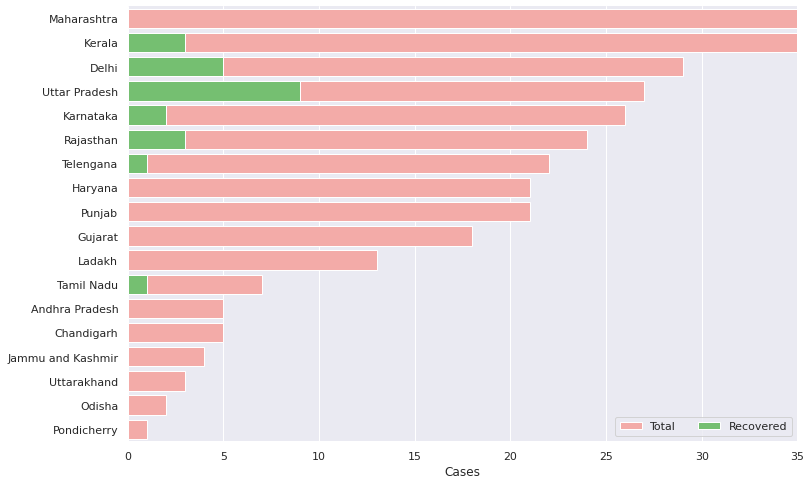

In [66]:
f, ax = plt.subplots(figsize=(12, 8))
data = df_full[['Name of State / UT','Total cases','Cured/Discharged/Migrated','Deaths']]
data.sort_values('Total cases',ascending=False,inplace=True)
sns.set_color_codes("pastel")
sns.barplot(x="Total cases", y="Name of State / UT", data=data,
            label="Total", color="r")

sns.set_color_codes("muted")
sns.barplot(x="Cured/Discharged/Migrated", y="Name of State / UT", data=data,
            label="Recovered", color="g")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 35), ylabel="",
       xlabel="Cases")
sns.despine(left=True, bottom=True)

1.7 How the Coronavirus cases are rising?

In [67]:
# Rise in COVID-19 cases in India
fig = go.Figure()
fig.add_trace(go.Scatter(x=dbd_India['Date'], y=dbd_India['Total Cases'],
                    mode='lines+markers',name='Total Cases'))

fig.add_trace(go.Scatter(x=dbd_India['Date'], y=dbd_India['Recovered'], 
                mode='lines',name='Recovered'))
fig.add_trace(go.Scatter(x=dbd_India['Date'], y=dbd_India['Active'], 
                mode='lines',name='Active'))
fig.add_trace(go.Scatter(x=dbd_India['Date'], y=dbd_India['Deaths'], 
                mode='lines',name='Deaths'))
        
    
fig.update_layout(title_text='Trend of Coronavirus Cases in India(Cumulative cases)',plot_bgcolor='rgb(250, 242, 242)')

fig.show(renderer = "colab")


# New COVID-19 cases reported daily in India

import plotly.express as px
fig = px.bar(dbd_India, x="Date", y="New Cases", barmode='group',
             height=400)
fig.update_layout(title_text='New Coronavirus Cases in India per day',plot_bgcolor='rgb(250, 242, 242)')

fig.show(renderer = "colab")

# B.] Checking if the trend is similar to Italy and South Korea

2.1 Cumulative cases in India, Italy and South Korea

In [68]:
fig = px.bar(dbd_Italy, x="Date", y="Total Cases", color='Total Cases', orientation='v', height=600,
             title='Confirmed Cases in Italy', color_discrete_sequence = px.colors.cyclical.mygbm)

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show(renderer = "colab")

fig = px.bar(dbd_Korea, x="Date", y="Total Cases", color='Total Cases', orientation='v', height=600,
             title='Confirmed Cases in Korea', color_discrete_sequence = px.colors.cyclical.mygbm)

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show(renderer = "colab")

fig = px.bar(dbd_India, x="Date", y="Total Cases", color='Total Cases', orientation='v', height=600,
             title='Confirmed Cases in India', color_discrete_sequence = px.colors.cyclical.mygbm)

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show(renderer = "colab")

2.2 Comparison between the rise of cases in S.Korea, Italy and India

In [69]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("S.Korea","Italy", "India"))

fig.add_trace(go.Bar(x=dbd_Korea['Date'], y=dbd_Korea['Total Cases'],
                    marker=dict(color=dbd_Korea['Total Cases'], coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Bar(x=dbd_Italy['Date'], y=dbd_Italy['Total Cases'],
                    marker=dict(color=dbd_Italy['Total Cases'], coloraxis="coloraxis")),
              1, 2)

fig.add_trace(go.Bar(x=dbd_India['Date'], y=dbd_India['Total Cases'],
                    marker=dict(color=dbd_India['Total Cases'], coloraxis="coloraxis")),
              2, 1)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False,title_text="Total Confirmed cases(Cumulative)")

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show(renderer = "colab")

In [70]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("S.Korea","Italy", "India"))

fig.add_trace(go.Scatter(x=dbd_Korea['Date'], y=dbd_Korea['Total Cases'],
                    marker=dict(color=dbd_Korea['Total Cases'], coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Scatter(x=dbd_Italy['Date'], y=dbd_Italy['Total Cases'],
                    marker=dict(color=dbd_Italy['Total Cases'], coloraxis="coloraxis")),
              1, 2)

fig.add_trace(go.Scatter(x=dbd_India['Date'], y=dbd_India['Total Cases'],
                    marker=dict(color=dbd_India['Total Cases'], coloraxis="coloraxis")),
              2, 1)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False,title_text="Trend of Coronavirus cases")

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show(renderer = "colab")

2.3 Trend after surpassing 100 cases

In [71]:
import plotly.graph_objects as go
import numpy as np

title = 'Main Source for News'
labels = ['S.Korea', 'Italy', 'India']
colors = ['rgb(0,128,0)', 'rgb(255,0,0)', 'rgb(49,130,189)']

mode_size = [8, 8, 12]
line_size = [2, 2, 4]

fig = go.Figure()


fig.add_trace(go.Scatter(x=dbd_Korea['Days after surpassing 100 cases'], 
                 y=dbd_Korea['Total Cases'],mode='lines',
                 name=labels[0],
                 line=dict(color=colors[0], width=line_size[0]),            
                 connectgaps=True,
    ))
fig.add_trace(go.Scatter(x=dbd_Italy['Days after surpassing 100 cases'], 
                 y=dbd_Italy['Total Cases'],mode='lines',
                 name=labels[1],
                 line=dict(color=colors[1], width=line_size[1]),            
                 connectgaps=True,
    ))

fig.add_trace(go.Scatter(x=dbd_India['Days after surpassing 100 cases'], 
                 y=dbd_India['Total Cases'],mode='lines',
                 name=labels[2],
                 line=dict(color=colors[2], width=line_size[2]),            
                 connectgaps=True,
    ))
    
    
    
annotations = []

annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Days after surpassing 100 cases ',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))

fig.update_layout(annotations=annotations,plot_bgcolor='white',yaxis_title='Cumulative cases')

fig.show(renderer = "colab")